In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from PIL import Image
import os
from torch.optim import lr_scheduler
from database2 import DehazingDataset

In [2]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Discriminator
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, stride=2, padding=1)
        )

    def forward(self, x):
        x = self.model(x)
        # Perform global average pooling
        x = torch.mean(x, dim=(2, 3))
        return torch.sigmoid(x)



In [4]:
root_dir = 'Task2Dataset'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
transform = transforms.Compose([
                                #  transforms.Resize((224, 224)), # ASSUMING NO NEED FOR RESIZING AS ALL IMAGES ARE ALREADY 256*256
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                 ])

train_dataset = DehazingDataset(train_dir, transform)
val_dataset = DehazingDataset(val_dir, transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [5]:
# Define the generator and discriminator
generator = Generator()
discriminator = Discriminator()

In [6]:

# Define the loss function and optimizer
bce_loss = nn.BCELoss()
l1_loss = nn.L1Loss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [7]:
lr_step_size = 2
lr_gamma = 0.5

schedulerG = lr_scheduler.StepLR(optimizer_G, lr_step_size, lr_gamma)
schedulerD = lr_scheduler.StepLR(optimizer_D, lr_step_size, lr_gamma)

In [8]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    schedulerG.step()
    schedulerD.step()

    # Initialize total losses for the epoch
    g_total_loss = 0
    d_total_loss = 0

    # Training the generator and discriminator
    for hazy_imgs, clean_imgs in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        # Training the discriminator
        discriminator.zero_grad()
        real_imgs = clean_imgs

        # GENERATOR TAKES HAZY IMAGES AS INPUT
        fake_imgs = generator(hazy_imgs)

        real_labels = torch.ones(real_imgs.size(0), 1)
        fake_labels = torch.zeros(fake_imgs.size(0), 1)

        # PREDICTIONS OF DISCRIMINATOR FOR REAL IMAGES
        real_outputs = discriminator(real_imgs)

        # PREDICTIONS OF DISCRIMINATOR FOR FAKE IMAGES
        fake_outputs = discriminator(fake_imgs.detach())

        d_loss_real = bce_loss(real_outputs, real_labels)
        d_loss_fake = bce_loss(fake_outputs, fake_labels)
        d_loss = d_loss_real + d_loss_fake

        # Update discriminator
        d_loss.backward()
        optimizer_D.step()

        # Training the generator
        generator.zero_grad()
        fake_imgs = generator(hazy_imgs)
        fake_outputs = discriminator(fake_imgs)
        g_loss = bce_loss(fake_outputs, real_labels)

        # Compute reconstruction loss
        g_res_loss = l1_loss(fake_imgs, clean_imgs)

        # Update generator
        g_complete_loss = (g_loss + g_res_loss)
        g_complete_loss.backward()
        optimizer_G.step()

        # Add discriminator and generator losses to total losses
        d_total_loss += d_loss.item()
        g_total_loss += g_loss.item() + g_res_loss.item()  # Add reconstruction loss to total generator loss

    # Print losses
    print(f"Epoch [{epoch + 1}/{num_epochs}], Generator Loss: {g_total_loss / len(train_dataloader):.4f}, Discriminator Loss: {d_total_loss / len(train_dataloader):.4f}")

# Save the trained models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


/opt/homebrew/Cellar/jupyterlab/4.1.5/libexec/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Epoch 1/10: 100%|███████████████████████████| 239/239 [1:38:32<00:00, 24.74s/it]


Epoch [1/10], Generator Loss: 1.6251, Discriminator Loss: 1.2522


Epoch 2/10: 100%|███████████████████████████| 239/239 [1:32:57<00:00, 23.34s/it]


Epoch [2/10], Generator Loss: 2.1371, Discriminator Loss: 0.8444


Epoch 3/10: 100%|███████████████████████████| 239/239 [1:14:11<00:00, 18.62s/it]


Epoch [3/10], Generator Loss: 2.8351, Discriminator Loss: 0.5403


Epoch 4/10: 100%|█████████████████████████████| 239/239 [57:28<00:00, 14.43s/it]


Epoch [4/10], Generator Loss: 2.6731, Discriminator Loss: 0.4575


Epoch 5/10: 100%|█████████████████████████████| 239/239 [59:40<00:00, 14.98s/it]


Epoch [5/10], Generator Loss: 2.8834, Discriminator Loss: 0.4066


Epoch 6/10: 100%|█████████████████████████████| 239/239 [59:17<00:00, 14.88s/it]


Epoch [6/10], Generator Loss: 2.6865, Discriminator Loss: 0.3859


Epoch 7/10: 100%|███████████████████████████| 239/239 [1:04:51<00:00, 16.28s/it]


Epoch [7/10], Generator Loss: 2.8036, Discriminator Loss: 0.3529


Epoch 8/10: 100%|█████████████████████████████| 239/239 [50:56<00:00, 12.79s/it]


Epoch [8/10], Generator Loss: 2.5605, Discriminator Loss: 0.3894


Epoch 9/10: 100%|█████████████████████████████| 239/239 [49:30<00:00, 12.43s/it]


Epoch [9/10], Generator Loss: 2.6427, Discriminator Loss: 0.3625


Epoch 10/10: 100%|████████████████████████████| 239/239 [48:52<00:00, 12.27s/it]

Epoch [10/10], Generator Loss: 2.6069, Discriminator Loss: 0.3475


In [ ]:
real_outputs.shape

torch.Size([8192, 1])

In [ ]:
real_labels.shape

torch.Size([32, 1])

In [ ]:
fake_outputs.shape

torch.Size([8192, 1])

In [ ]:
#output is 256*32 instead of 32 outputs

In [9]:
torch.save(generator.state_dict(), 'generator_l1loss_scheduler.pth')
torch.save(discriminator.state_dict(), 'discriminator_l1loss_scheduler.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 3 is out of bounds for dimension 0 with size 3

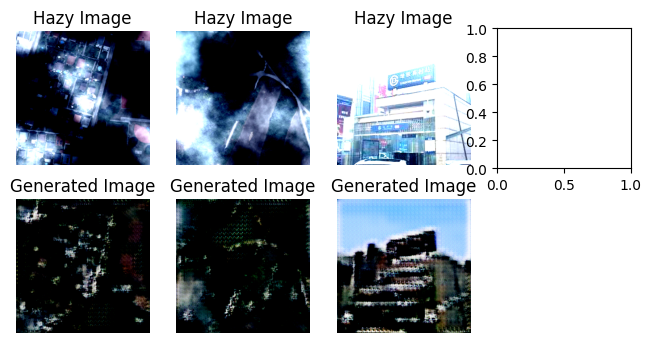

In [10]:
num_samples = 5
import matplotlib.pyplot as plt

generated_images = generator(hazy_imgs[:num_samples]).detach().cpu()

plt.figure(figsize=(10, 4))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(hazy_imgs[i].permute(1, 2, 0))  # Assuming images are in CHW format
    plt.title('Hazy Image')
    plt.axis('off')

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(generated_images[i].permute(1, 2, 0))  # Assuming images are in CHW format
    plt.title('Generated Image')
    plt.axis('off')

plt.tight_layout()
plt.show()
            